# Pairs and bot analysis

## Configurations

In [89]:
# TODO
# - Continous graph of how quality of pairs change with time
# - Divide the analysis into segments:
# 1. Configuration
# 2. Data loading
# 3. precalculation like is_paper or quote_currency, no filtration or deletion of data
# 4. Pair or bot analysis with filtration and trimming of data
# - dayily ROI

In [90]:
# imports
import pandas as pd
from datetime import timedelta
import numpy as np
from os import walk
import ast

In [91]:
# constants

SHOW_MAX_ROWS = 50
HISTORY_PATH = "../resources/history_files/"
_, _, DEALS_HISTORY_FILE_NAMES_LIST = next(walk(HISTORY_PATH))
DEALS_HISTORY_FILE_NAME = f"{len(DEALS_HISTORY_FILE_NAMES_LIST)} histories combined"
DATETIME_FORMAT='%d/%m/%Y %H:%M:%S'
QUOTE_PAIR = {"USDT"}
ALLOWED_STATUS = {"completed", "panic_sold"}
BINNING_PAIRS_STEP = timedelta(days=7)
# statistical trimming of most long and most short trades (by duration) for better averages in %
STAT_TRIM = False
TOP_TRIMMING = 0.98
BOTTOM_TRIMMING = 0.02

In [92]:
# filtration and preparation of the dataset

pd.set_option('display.max_rows', SHOW_MAX_ROWS)
pd.set_option("display.precision", 4)
COLUMNS = ["deal_id",
           "bot_id",
           "bot",
           "status",
           "pair","created_at",
           "closed_at", "duration",
           "profit_percentage_from_total_volume",
           "final_profit", "bought_volume",
          "signals", "account",
           "quote", "base", "is_paper", "owner"]

def add_owner(df, file_name):
    name = file_name.split("_")[0]
    df["owner"] = name
    return df

frames = [add_owner(pd.read_csv(HISTORY_PATH+file_name, sep=';'), file_name) for file_name in DEALS_HISTORY_FILE_NAMES_LIST]
df = pd.concat(frames)

# parsing
df = df[~df["bot_id"].isnull()]
df["bot_id"] = df["bot_id"].astype(int)
df["deal_id"] = df["deal_id"].astype(int)
df["created_at"] = pd.to_datetime(df["created_at"], format=DATETIME_FORMAT, errors='coerce')
df["closed_at"] = pd.to_datetime(df["closed_at"],  format=DATETIME_FORMAT, errors='coerce')

# adding columns
df["quote"] = df["pair"].str.split("_").str[0]
df["base"] = df["pair"].str.split("_").str[1]
df["is_paper"] = df["account"].str.startswith("Paper Account ")

unique_quote_currencies = {str(pair).split("_")[0] for pair in df["pair"].unique()}
data = {'unique bots': [len(df["bot_id"].unique())],
        'deals count' : [len(df)],
        'unique pairs' : [len(df["pair"].unique())],
        'unique quotes' : [len(unique_quote_currencies)]
        }
pd.DataFrame(unique_quote_currencies)
pd.DataFrame(data, index=["Data set preview"])

,unique bots,deals count,unique pairs,unique quotes
Data set preview,459,108761,685,6


In [93]:
QUOTE_GROUPBY_AGGREGATE = {"deal_id": "count", "pair": "nunique"}
QUOTE_GROUPBY_RENAME = {"deal_id": "deals count", "pair": "traded unique pairs"}
df.groupby(["quote"]).aggregate(QUOTE_GROUPBY_AGGREGATE).rename(columns=QUOTE_GROUPBY_RENAME)

,deals count,traded unique pairs
quote,,
AUD,5,1
BNB,373,56
BTC,1531,224
BUSD,62376,149
USD,54,15
USDT,44422,240


In [94]:
OWNER_GROUPBY_AGGREGATE = {"deal_id": "count", "bot_id": "nunique"}
OWNER_GROUPBY_RENAME = {"deal_id": "deals count", "pair": "unique bots"}
df.groupby(["owner"]).aggregate(OWNER_GROUPBY_AGGREGATE).rename(columns=OWNER_GROUPBY_RENAME)

,deals count,bot_id
owner,,
Arun,514,9
Cosmin,19793,56
Dan,4000,35
Hazhir,869,12
Nando,3807,17
SJ,11846,82
Serge,23239,83
Stefan,589,1
Sunep,38470,136


In [95]:
## trimm and filter
dff = df.loc[:,COLUMNS]
dff = dff[dff["status"].isin(ALLOWED_STATUS)]
if QUOTE_PAIR and len(QUOTE_PAIR) > 0:
    dff = dff[dff["quote"].isin(QUOTE_PAIR)]
# dff = dff[dff["owner"] == "Stefan"]
if STAT_TRIM:
    dff = dff[dff.duration < dff.duration.quantile(TOP_TRIMMING)]
    dff = dff[dff.duration > dff.duration.quantile(BOTTOM_TRIMMING)]
print(f"After filtrating there are {len(dff)} entries")
dff.head(3)

After filtrating there are 40711 entries


,deal_id,bot_id,bot,status,pair,created_at,closed_at,duration,profit_percentage_from_total_volume,final_profit,bought_volume,signals,account,quote,base,is_paper,owner
0,292624911,2618034,AusArun USDT Long Bot #3,completed,USDT_XLM,2021-02-10 22:51:22,2021-02-10 23:32:34,2472.2303,2.3352,0.2358,10.0993,"[{""options"":{""time"":""1m"",""type"":""strong_buy""},...",AusArun,USDT,XLM,False,Arun
1,292626001,2618034,AusArun USDT Long Bot #3,completed,USDT_XRP,2021-02-10 22:52:21,2021-02-11 00:20:34,5293.3474,1.0220,0.6148,60.1544,"[{""options"":{""time"":""1m"",""type"":""strong_buy""},...",AusArun,USDT,XRP,False,Arun
2,292626568,2618034,AusArun USDT Long Bot #3,completed,USDT_DOT,2021-02-10 22:52:44,2021-02-10 23:33:32,2448.6980,1.3018,2.8210,216.7049,"[{""options"":{""time"":""1m"",""type"":""strong_buy""},...",AusArun,USDT,DOT,False,Arun


In [96]:
TIME_BIN_LABEL = "time frame"
min_created_at_date = dff["created_at"].min()
max_created_at_date = dff["created_at"].max()

created_at_bins = [min_created_at_date]
while min_created_at_date < max_created_at_date+BINNING_PAIRS_STEP:
    min_created_at_date += BINNING_PAIRS_STEP
    created_at_bins.append(min_created_at_date)
    
bin_labels = [i+1 for i in range(len(created_at_bins)-1)]
dff[TIME_BIN_LABEL] = pd.cut(dff["created_at"], bins=created_at_bins, include_lowest=True, labels=bin_labels)
#pd.qcut(dff["created_at"], q=len(created_at_bins)-1)

# Pair analysis

In [97]:
# configs
TRADES_MIN_TRESHOLD = 5 #30 # Pairs with deals count less than this number will not appear in the analysis
# labels
AVG_PROFIT_PER_DEAL_LABEL = "avg_profit_per_deal"
AVG_DURATION_LABEL = "avg_duration_of_deals"
AVG_PROFIT_PER_HOUR_LABEL = "avg_profit_per_hour"
COUNT_LABEL = "deals"

In [98]:
# group by pair, craete  columns average duration and average profit
DFAN_GROUPBY = [ "pair"]
dfan = dff.groupby(DFAN_GROUPBY).aggregate({"pair": "count", "duration": "mean", "final_profit" : "mean"})
dfan.rename(columns={"duration": AVG_DURATION_LABEL, 
                     "final_profit" : AVG_PROFIT_PER_DEAL_LABEL, 
                     "pair": COUNT_LABEL},
           inplace=True)
# filter only Pairs with decent ammount of trades
if TRADES_MIN_TRESHOLD:
    dfan = dfan[dfan[COUNT_LABEL] > TRADES_MIN_TRESHOLD]
# create new avg_profit_per_hour column
dfan[AVG_PROFIT_PER_HOUR_LABEL] = dfan[AVG_PROFIT_PER_DEAL_LABEL]/dfan[AVG_DURATION_LABEL]*60*60
# make duration human readable
#dfan[AVG_DURATION_LABEL] = dfan[AVG_DURATION_LABEL].apply(lambda x: timedelta(seconds=x))
dfan[AVG_DURATION_LABEL] = dfan[AVG_DURATION_LABEL].apply(lambda x: pd.to_timedelta(x,unit='s'))
dfan

,deals,avg_duration_of_deals,avg_profit_per_deal,avg_profit_per_hour
pair,,,,
USDT_1INCH,153,09:28:39.055240,0.7218,0.0762
USDT_AAVE,476,03:41:57.564579,0.0908,0.0246
USDT_AAVEDOWN,458,00:49:57.614223,0.9334,1.1209
USDT_AAVEUP,484,00:25:34.506201,0.4300,1.0088
USDT_ACM,16,00:53:46.587609,1.3120,1.4639
...,...,...,...,...
USDT_YFIUP,521,02:13:56.019416,0.7571,0.3392
USDT_ZEC,137,09:05:20.324349,0.6507,0.0716
USDT_ZEN,127,05:10:01.228960,0.4223,0.0817


## Plots

In [99]:
#configs
plot_size = (20*4,5*4)
# plot preparations

dfplot = dfan
dfplot = dfplot.reset_index()
dfplot["pair"] = dfplot["pair"] + dfplot[COUNT_LABEL].apply(lambda c: f" ({c})")
del dfplot[COUNT_LABEL]
dfplot = dfplot.set_index("pair")

### Average Profit / h

In [100]:
#pl = dfplot.sort_values(AVG_PROFIT_PER_HOUR_LABEL)[AVG_PROFIT_PER_HOUR_LABEL].plot(kind="bar",
#                                                                            figsize=plot_size,
#                                                                           title=f'Average deal profit per hour, {DEALS_HISTORY_FILE_NAME}')
#pl.set_ylabel("profit, $")
#pl.set_xlabel(f"pair (deals count), {QUOTE_PAIR}")
#pl

### Average Duration in minutes

<AxesSubplot:title={'center':'Average deal duration in minutes, 16 histories combined'}, xlabel="pair (deals count), {'USDT'}", ylabel='t, minutes'>

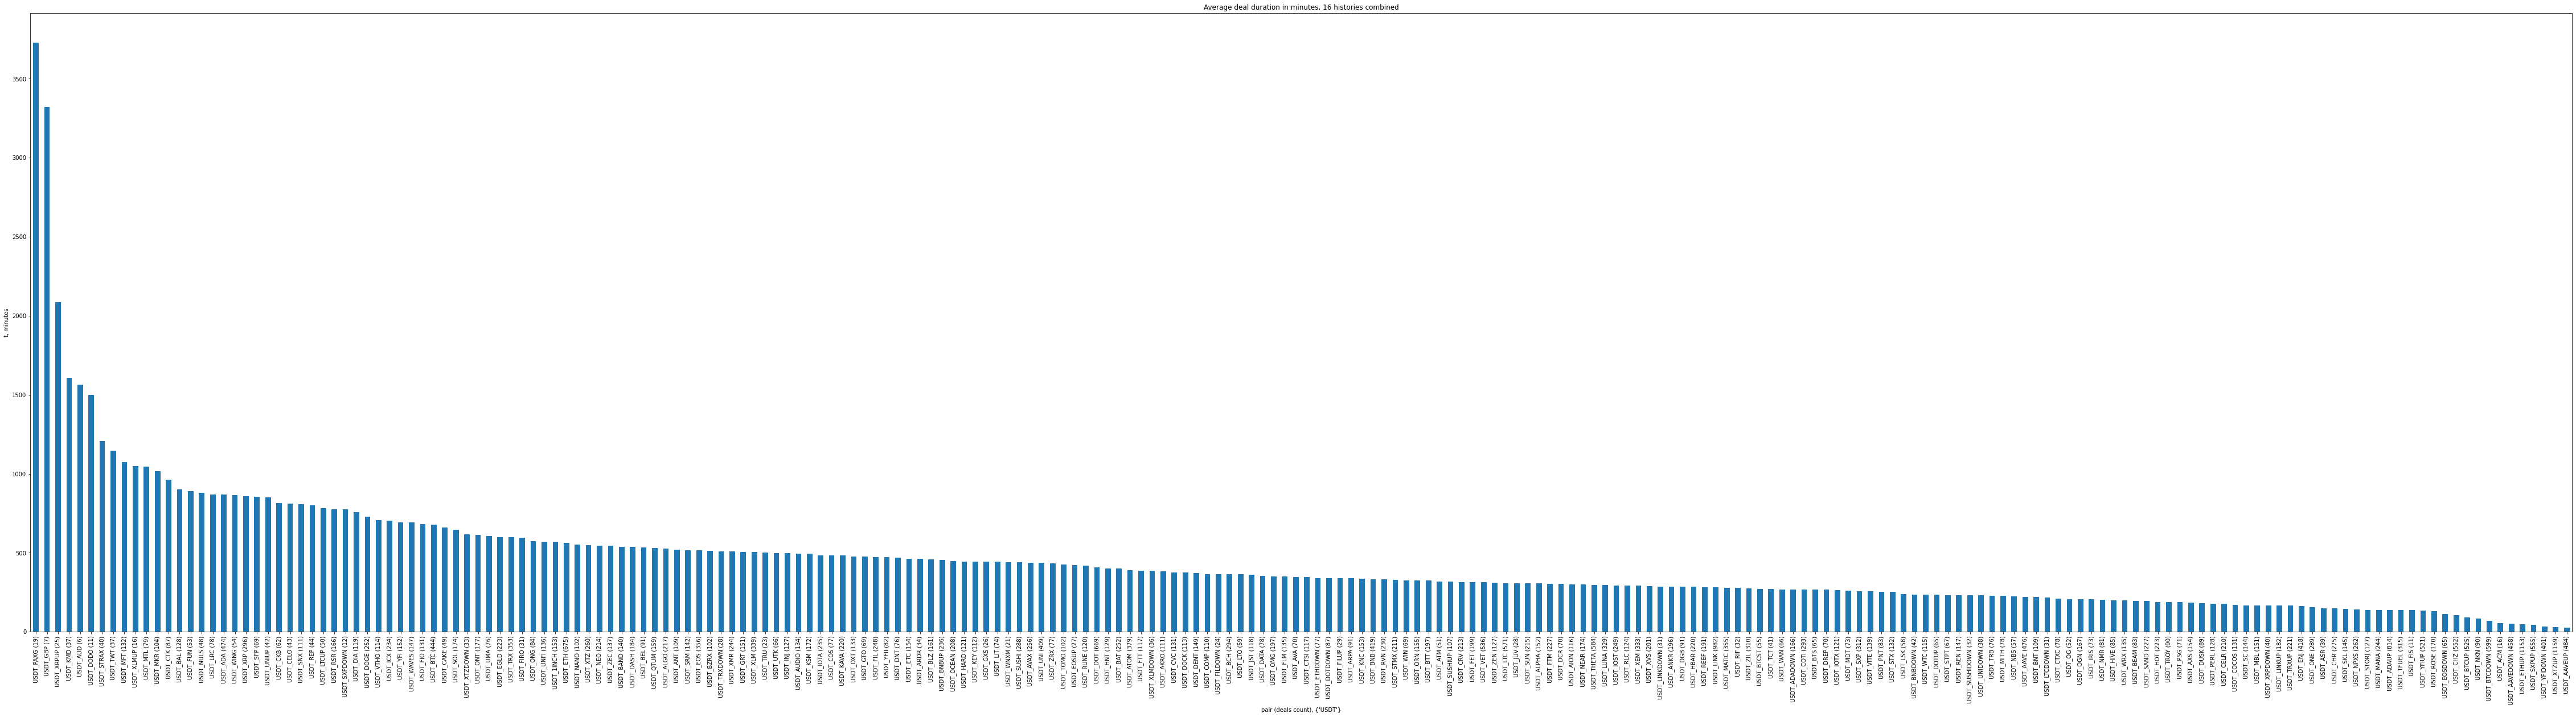

In [101]:
pl = (dfplot.sort_values(by=AVG_DURATION_LABEL, ascending=False)[AVG_DURATION_LABEL].dt.total_seconds()/60).plot(kind="bar",
                                                                                          figsize=plot_size,
                                                                                          title=f'Average deal duration in minutes, {DEALS_HISTORY_FILE_NAME}')
pl.set_ylabel("t, minutes")
pl.set_xlabel(f"pair (deals count), {QUOTE_PAIR}")
pl

## Low quality pairs

In [102]:
# configurations

QUANTILE = 1.0 / 3

In [103]:
# calculations

#low_pph = dfan[dfan[AVG_PROFIT_PER_HOUR_LABEL] < dfan[AVG_PROFIT_PER_HOUR_LABEL].quantile(QUANTILE)]
#high_dur = dfan[dfan[AVG_DURATION_LABEL] > dfan[AVG_DURATION_LABEL].quantile(1-QUANTILE)]
#low_quality_pairs = set(low_pph.index.tolist()).intersection(set(high_dur.index.tolist()))
#low_quality_pairs = set(low_pph.index.tolist() + high_dur.index.tolist())

#dfan[dfan.index.isin(low_quality_pairs)].reset_index()

In [104]:
# duration percentile
dur_max = dfan[AVG_DURATION_LABEL].max()
dur_min = dfan[AVG_DURATION_LABEL].min()
dur_length = dur_max - dur_min
def get_dur_percentile(dur):
    # 1 is highest quality, 0 lowest
    return 1 - ((dur - dur_min) / dur_length)

dfan["dur_percentile"] = get_dur_percentile(dfan[AVG_DURATION_LABEL])

In [105]:
# Profit per time percentile
ppt_max = dfan[AVG_PROFIT_PER_HOUR_LABEL].max()
ppt_min = dfan[AVG_PROFIT_PER_HOUR_LABEL].min()
ppt_length = ppt_max - ppt_min
def get_ppt_percentile(ppt):
    # 1 is highest quality, 0 lowest
    return (ppt - ppt_min) / ppt_length

dfan["ppt_percentile"] = get_ppt_percentile(dfan[AVG_PROFIT_PER_HOUR_LABEL])

In [106]:
QUALITY_SCORE_LABEL = "quality score"
dfan[QUALITY_SCORE_LABEL] = (dfan["ppt_percentile"] + dfan["dur_percentile"]) / 2
dfan = dfan.sort_values(by=QUALITY_SCORE_LABEL, ascending=True)
#dfan

In [107]:
#pl = dfan[QUALITY_SCORE_LABEL].plot(kind="bar",
#                                                                            figsize=plot_size,
#                                                                            title=f'{QUALITY_SCORE_LABEL}, {DEALS_HISTORY_FILE_NAME}')
#pl.set_ylabel("profit, $")
#pl.set_xlabel(f"pair (deals count), {QUOTE_PAIR}")
#pl

In [108]:
pd.set_option('display.max_rows', 250)
dflow = dfan[dfan[QUALITY_SCORE_LABEL] < dfan[QUALITY_SCORE_LABEL].quantile(.25)]
dfan.sort_values(by=QUALITY_SCORE_LABEL, ascending=False).reset_index()
#dflow.reset_index()

,pair,deals,avg_duration_of_deals,avg_profit_per_deal,avg_profit_per_hour,dur_percentile,ppt_percentile,quality score
0,USDT_YFIDOWN,401,0 days 00:32:46.241818,0.9381,1.7176,0.9981,1.0000,0.9990
1,USDT_SXPUP,555,0 days 00:45:52.846110,1.2093,1.5815,0.9945,0.9302,0.9623
2,USDT_ACM,16,0 days 00:53:46.587609,1.3120,1.4639,0.9924,0.8699,0.9311
3,USDT_XTZUP,1159,0 days 00:28:50.915509,0.6958,1.4472,0.9991,0.8613,0.9302
4,USDT_AAVEDOWN,458,0 days 00:49:57.614223,0.9334,1.1209,0.9934,0.6940,0.8437
5,USDT_AAVEUP,484,0 days 00:25:34.506201,0.4300,1.0088,1.0000,0.6365,0.8182
6,USDT_NKN,90,0 days 01:24:49.347296,1.0313,0.7295,0.9840,0.4932,0.7386
7,USDT_PERL,128,0 days 02:59:17.297178,1.4836,0.4965,0.9585,0.3738,0.6661
8,USDT_ETHUP,1153,0 days 00:46:28.022910,0.3146,0.4062,0.9944,0.3275,0.6609
9,USDT_ROSE,170,0 days 02:11:30.717706,0.9381,0.4280,0.9714,0.3386,0.6550


## Bot analysis

In [109]:
#configs
TIME_FRAME = "day"
SHOW_HEAD = 10
BOT_MIN_ONLINE_THRESHOLD = timedelta(days=1)
BOT_TRADES_MIN_THRESHOLD = 40
TIME_ADJUSTMENT_RATIO = {"day": 60*60*24, "hour": 60*60, "minute": 60}[TIME_FRAME]

# labels
BOT_ONLINE_LABEL = "bot online time"
PROFIT_PER_TIME_LABEL = f"gain / trading time ({TIME_FRAME})"
PROFIT_PER_TIME_LABEL_NORMALIZED = PROFIT_PER_TIME_LABEL+" (normalized by bought volume)" #normalizing
PROFIT_PER_TIME_ONLINE_LABEL = f"gain / {BOT_ONLINE_LABEL} ({TIME_FRAME})"
PROFIT_PER_TIME_ONLINE_LABEL_NORMALIZED = PROFIT_PER_TIME_ONLINE_LABEL +" (normalized by bought volume)" 
ROI_LABEL = f"ROI, % {TIME_FRAME}"

In [110]:
#presorting filters
#df_roi_an_pre = dff[dff["signals"].str.contains("qfl")]
#df_roi_an_pre = dff[dff["bot_id"] == 2933264]



# analysis
df_roi_an = dff.groupby(["bot_id"]).aggregate(
    {"bot": "first",
    "is_paper": "first",
    "owner": "first",
     "quote": "first",
     "pair": "count", 
     "duration": "sum",
     "final_profit" : "sum", 
     "bought_volume": "sum",
    "created_at": "min",
    "closed_at": "max"})
# df_roi_an.rename(columns = {"duration": "duration, sum", "final_profit" : "final_profit, sum"}, inplace=True)
df_roi_an["created_at_max"] = dff.groupby(["bot_id"])["created_at"].max()

df_roi_an.rename(columns = {"bot": f"{QUOTE_PAIR} bot"}, inplace = True)
df_roi_an["duration"] = df_roi_an["duration"] / TIME_ADJUSTMENT_RATIO
df_roi_an.rename(columns={"pair": COUNT_LABEL}, inplace=True)
#df_roi_an[BOT_ONLINE_LABEL] = df_roi_an["closed_at"] - df_roi_an["created_at"]
df_roi_an[BOT_ONLINE_LABEL] = df_roi_an["created_at_max"] - df_roi_an["created_at"]
df_roi_an[PROFIT_PER_TIME_LABEL] = df_roi_an["final_profit"] / df_roi_an["duration"]
df_roi_an[PROFIT_PER_TIME_LABEL_NORMALIZED] = df_roi_an[PROFIT_PER_TIME_LABEL] / df_roi_an["bought_volume"]
df_roi_an[PROFIT_PER_TIME_ONLINE_LABEL] = df_roi_an["final_profit"] / df_roi_an[BOT_ONLINE_LABEL].dt.total_seconds() * TIME_ADJUSTMENT_RATIO
df_roi_an[PROFIT_PER_TIME_ONLINE_LABEL_NORMALIZED] = df_roi_an[PROFIT_PER_TIME_ONLINE_LABEL] / df_roi_an["bought_volume"]
del df_roi_an["created_at"]
del df_roi_an["closed_at"]
del df_roi_an["created_at_max"]
df_roi_an[ROI_LABEL] = df_roi_an["final_profit"] / (df_roi_an[BOT_ONLINE_LABEL].dt.total_seconds()/(TIME_ADJUSTMENT_RATIO)) /  df_roi_an["bought_volume"] * 100
# df_roi_an[ROI_LABEL] = df_roi_an["final_profit"] / (df_roi_an["duration"] /  df_roi_an["bought_volume"] * 100

# filters
print(f"Bot min deals threshold = {BOT_TRADES_MIN_THRESHOLD}")
df_roi_an = df_roi_an[df_roi_an[COUNT_LABEL] > BOT_TRADES_MIN_THRESHOLD]#filters
if BOT_MIN_ONLINE_THRESHOLD:
    print(f"Bot min online time threshold = {BOT_MIN_ONLINE_THRESHOLD}")
    df_roi_an = df_roi_an[df_roi_an[BOT_ONLINE_LABEL] > BOT_MIN_ONLINE_THRESHOLD]
    
### custom filters

#df_roi_an["avg_bought_volume_per_deal"] = df_roi_an["bought_volume"] / df_roi_an[COUNT_LABEL]
#df_roi_an["ROI, %"] = df_roi_an["final_profit"] / df_roi_an["bought_volume"] * 100
#df_roi_an["avg_profit"] = df_roi_an["avg_bought_volume_per_deal"] * ((100+df_roi_an["ROI, %"])/100 - 1)  
print(f"Sorted by '{PROFIT_PER_TIME_LABEL_NORMALIZED}'")
df_roi_an.sort_values(by=PROFIT_PER_TIME_LABEL_NORMALIZED, ascending=False).head(SHOW_HEAD)

Bot min deals threshold = 40
Bot min online time threshold = 1 day, 0:00:00
Sorted by 'gain / trading time (day) (normalized by bought volume)'


,{'USDT'} bot,is_paper,owner,quote,deals,duration,final_profit,bought_volume,bot online time,gain / trading time (day),gain / trading time (day) (normalized by bought volume),gain / bot online time (day),gain / bot online time (day) (normalized by bought volume),"ROI, % day"
bot_id,,,,,,,,,,,,,,
3143463,FUTURES SJB LONG X25 THETA,False,SJ,USDT,110,0.3815,163.5792,56161.2077,1 days 12:49:09,428.7838,0.0076,106.6265,0.0019,0.1899
2676559,Gordon moderate,False,Sunep,USDT,212,25.5612,344.7403,17921.4678,30 days 04:08:08,13.4869,0.0008,11.4257,0.0006,0.0638
2933264,Binance USDT Long Bot,False,Sunep,USDT,63,61.4475,849.8599,19772.7372,9 days 22:18:45,13.8307,0.0007,85.5878,0.0043,0.4329
2684500,Paper Account 338149 USDT Long Bot,True,Sunep,USDT,138,48.3363,185.2287,5747.4128,30 days 08:54:11,3.8321,0.0007,6.0989,0.0011,0.1061
2972584,My composite bot_normal,True,Viktoria,USDT,175,36.9524,310.1536,13561.5063,11 days 15:09:54,8.3933,0.0006,26.6641,0.0020,0.1966
2676585,Long BinGMAIL Margin,False,Nando,USDT,54,28.8978,724.4337,42107.1828,2 days 04:35:10,25.0688,0.0006,330.6274,0.0079,0.7852
2745930,AusArun USDT Long Bot JR,False,Arun,USDT,41,13.4706,133.9063,19958.7983,6 days 20:11:07,9.9407,0.0005,19.5739,0.0010,0.0981
2684487,Paper Account 338149 USDT Long Bot,True,Sunep,USDT,60,30.9775,37.1024,2494.2064,30 days 06:59:55,1.1977,0.0005,1.2248,0.0005,0.0491
2891770,Long Bot,True,Nando,USDT,383,83.0720,2055.4112,53135.8062,14 days 20:30:08,24.7425,0.0005,138.3718,0.0026,0.2604


In [111]:
print(f"Sorted by '{PROFIT_PER_TIME_ONLINE_LABEL_NORMALIZED}'")
df_roi_an.sort_values(by=PROFIT_PER_TIME_ONLINE_LABEL_NORMALIZED, ascending=False).head(SHOW_HEAD)

Sorted by 'gain / bot online time (day) (normalized by bought volume)'


,{'USDT'} bot,is_paper,owner,quote,deals,duration,final_profit,bought_volume,bot online time,gain / trading time (day),gain / trading time (day) (normalized by bought volume),gain / bot online time (day),gain / bot online time (day) (normalized by bought volume),"ROI, % day"
bot_id,,,,,,,,,,,,,,
2676585,Long BinGMAIL Margin,False,Nando,USDT,54,28.8978,724.4337,42107.1828,2 days 04:35:10,25.0688,5.9536e-04,330.6274,0.0079,0.7852
2965790,SJ 2 MAR | SPOT RSI7 3m<40 TV60 VOL600 | BO/SO...,True,Serge,USDT,186,69.8524,334.7662,16152.5913,3 days 18:37:34,4.7925,2.9670e-04,88.6542,0.0055,0.5489
2700579,James base,False,Serge,USDT,289,67.6375,114.9947,13070.0445,1 days 22:59:18,1.7002,1.3008e-04,58.7353,0.0045,0.4494
2933264,Binance USDT Long Bot,False,Sunep,USDT,63,61.4475,849.8599,19772.7372,9 days 22:18:45,13.8307,6.9948e-04,85.5878,0.0043,0.4329
2947387,SJ 2 MAR | SPOT RSI7 3m<40 TV60 VOL200 | BO/SO...,True,Serge,USDT,231,78.2421,394.2300,20125.6672,4 days 17:24:42,5.0386,2.5036e-04,83.4263,0.0041,0.4145
2947142,SJ 2 MAR | SPOT RSI7 3m<40 TV60 VOL50 | BO/SO ...,True,Serge,USDT,208,80.2109,356.3414,18163.1656,4 days 17:38:46,4.4426,2.4459e-04,75.2529,0.0041,0.4143
2666116,TG - 9648642b60,False,Sunep,USDT,232,99.7452,145.1564,9458.9854,3 days 20:48:39,1.4553,1.5385e-04,37.5361,0.0040,0.3968
2899715,Stoic bot,False,Sunep,USDT,163,173.3573,1571.3543,30123.0540,13 days 13:49:33,9.0643,3.0091e-04,115.7444,0.0038,0.3842
2929546,Paper Account 338149 USDT Long Bot,True,Sunep,USDT,98,98.9394,152.4922,3808.0669,10 days 18:58:47,1.5413,4.0474e-04,14.1317,0.0037,0.3711


In [112]:
print(f"Sorted by '{ROI_LABEL}'")
df_roi_an.sort_values(by=ROI_LABEL, ascending=False).head(SHOW_HEAD)

Sorted by 'ROI, % day'


,{'USDT'} bot,is_paper,owner,quote,deals,duration,final_profit,bought_volume,bot online time,gain / trading time (day),gain / trading time (day) (normalized by bought volume),gain / bot online time (day),gain / bot online time (day) (normalized by bought volume),"ROI, % day"
bot_id,,,,,,,,,,,,,,
2676585,Long BinGMAIL Margin,False,Nando,USDT,54,28.8978,724.4337,42107.1828,2 days 04:35:10,25.0688,5.9536e-04,330.6274,0.0079,0.7852
2965790,SJ 2 MAR | SPOT RSI7 3m<40 TV60 VOL600 | BO/SO...,True,Serge,USDT,186,69.8524,334.7662,16152.5913,3 days 18:37:34,4.7925,2.9670e-04,88.6542,0.0055,0.5489
2700579,James base,False,Serge,USDT,289,67.6375,114.9947,13070.0445,1 days 22:59:18,1.7002,1.3008e-04,58.7353,0.0045,0.4494
2933264,Binance USDT Long Bot,False,Sunep,USDT,63,61.4475,849.8599,19772.7372,9 days 22:18:45,13.8307,6.9948e-04,85.5878,0.0043,0.4329
2947387,SJ 2 MAR | SPOT RSI7 3m<40 TV60 VOL200 | BO/SO...,True,Serge,USDT,231,78.2421,394.2300,20125.6672,4 days 17:24:42,5.0386,2.5036e-04,83.4263,0.0041,0.4145
2947142,SJ 2 MAR | SPOT RSI7 3m<40 TV60 VOL50 | BO/SO ...,True,Serge,USDT,208,80.2109,356.3414,18163.1656,4 days 17:38:46,4.4426,2.4459e-04,75.2529,0.0041,0.4143
2666116,TG - 9648642b60,False,Sunep,USDT,232,99.7452,145.1564,9458.9854,3 days 20:48:39,1.4553,1.5385e-04,37.5361,0.0040,0.3968
2899715,Stoic bot,False,Sunep,USDT,163,173.3573,1571.3543,30123.0540,13 days 13:49:33,9.0643,3.0091e-04,115.7444,0.0038,0.3842
2929546,Paper Account 338149 USDT Long Bot,True,Sunep,USDT,98,98.9394,152.4922,3808.0669,10 days 18:58:47,1.5413,4.0474e-04,14.1317,0.0037,0.3711


In [113]:
show_id = 3016037
BOT_SHOW_FILTER = ["bot", 
                   "owner",
                  "is_paper",
                  "quote",
                   "bot_id", 
                   "bot_pairs",
                   "strategy",
                   "signals", 
                   "take_profit_condition",
                  "safety_order_volume / base_order_volume",
                  "safety_order_step_percentage",
                  "take_profit_type",
                  "max_safety_orders_count",
                  "martingale_volume_coefficient",
                  "martingale_step_coefficient",
                  "safety_order_volume",
                  "safety_order_volume_type",
                  "base_order_volume",
                  "base_order_volume_type"]
print(df[df["bot_id"] == show_id].iloc[0]["bot"])
for signal in ast.literal_eval((df[df["bot_id"] == show_id].iloc[0]["signals"])):
    print(signal)
df[df["bot_id"] == show_id].iloc[0][BOT_SHOW_FILTER]

SPOT SJB BREAK 3 (1) V20 - 1K -
{'options': {'time': '3m', 'points': 40}, 'strategy': 'rsi'}
{'options': {'time': '1m', 'type': 'strong_buy'}, 'strategy': 'trading_view'}


bot                                                          SPOT SJB BREAK 3 (1) V20 - 1K -
owner                                                                                     SJ
is_paper                                                                               False
quote                                                                                   BUSD
bot_id                                                                               3016037
bot_pairs                                                                                146
strategy                                                                                long
signals                                    [{"options":{"time":"3m","points":40},"strateg...
take_profit_condition                                                                      3
safety_order_volume / base_order_volume                                                    1
safety_order_step_percentage                                          